In [74]:
import copy
import heapq
import re
from dataclasses import dataclass
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.criteria import *
from alns.weight_schemes import *

In [3]:
% matplotlib inline

In [4]:
SEED = 5432

# The resource-constrained project scheduling problem

The following explanation is largely based on [this paper](https://pms2020.sciencesconf.org/300164/document).

The goal of the RCPSP is to schedule a set of project activities $V = \{ 0, 1, 2, \ldots, n \}$, such that the makespan of the project is minimised.
Each activity $i \in V$ has a duration $d_i \in \mathbb{N}$.
Precedence constraints impose that an activity $i \in V$ can only start after all its predecessor activities have been completed.
The precedence constraints are given by a set of edges $E \subset V \times V$, where $(i, j) \in E$ means that $i$ must be completed before $j$ can commence.
Resource constraints, on the other hand, impose that an activity can only be scheduled if sufficient resources are available.
There are $K = \{ 1, 2, \ldots, m \}$ renewable resources available, with $R_k$ indicating the availability of resource $k$.
Each activity $i \in V$ requires $r_{ik}$ units of resource $k$.
A solution to the RCPSP is a schedule of activities $S = \{ S_0, S_1, \ldots, S_n \}$, where $S_i$ is the starting time of activity $i$.
The project starts at time $S_0 = 0$, and completes at $S_n$, where activities $0$ and $n$ are dummy activities that represent the start and completion of the project, respectively.

In this notebook, we solve an instance of the RCPSP using ALNS.
In particular, we solve instance `j9041_6` of the [PSPLib](http://www.om-db.wi.tum.de/psplib/library.html) benchmark suite.
This instance consists of 90 jobs, and four resources.


## Data instance

In [5]:
@dataclass
class ProblemData:
    num_jobs: int
    num_resources: int

    duration: np.ndarray  # job durations
    successors: List[List[int]]  # job successors
    predecessors: List[List[int]]  # job predecessors
    needs: np.ndarray  # job resource needs
    resources: np.ndarray  # resource capacities

    @property
    def last_job(self) -> int:
        return self.num_jobs - 1

    @classmethod
    def read_instance(cls, path: str) -> "ProblemData":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLib format.

        Loosely based on:
        https://github.com/baobabsoluciones/hackathonbaobab2020.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2: req_idx - 1]:
            _, _, modes, num_succ, *jobs, _ = re.split("\s+", line)
            successors.append(list(map(lambda x: int(x) - 1, jobs)))

        predecessors = [[] for _ in range(len(successors))]

        for job in range(len(successors)):
            for succ in successors[job]:
                predecessors[succ].append(job)

        needs = []
        durations = []

        for line in lines[req_idx + 3: avail_idx - 1]:
            _, _, _, duration, *consumption, _ = re.split("\s+", line)

            needs.append(list(map(int, consumption)))
            durations.append(int(duration))

        _, *avail, _ = re.split("\s+", lines[avail_idx + 2])
        resources = list(map(int, avail))

        return ProblemData(len(durations),
                           len(resources),
                           np.array(durations),
                           successors,
                           predecessors,
                           np.array(needs),
                           np.array(resources))

In [22]:
instance = ProblemData.read_instance('j9041_6.sm')

UNSCHEDULED = -1  # sentinel value
destroy_pct = 0.15
RHO = 0.75  # resource utilisation threshold
Q = int(instance.num_jobs * destroy_pct)

## Solution state

In [243]:
@dataclass
class RcpspState(State):
    """
    Solution state for the resource-constrained project scheduling problem.

    We use a list representation of the scheduled jobs, where job i is
    scheduled before j if i precedes j (i.e., the jobs are sorted
    topologically).
    """
    jobs: List[int]

    @property
    def unscheduled(self) -> List[int]:
        return sorted(set(range(instance.num_jobs)) - set(self.jobs))

    @property
    def scheduled(self) -> List[int]:
        return sorted(self.jobs)

    def limits(self):
        pass

    def objective(self) -> int:
        schedule, _ = self.schedule()
        return schedule[instance.last_job]

    def schedule(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Computes a serial schedule from the list of jobs in the current
        solution. See Figure 1 in Fleszar and Hindi (2004) for the algorithm.
        Returns the schedule, and the resources used.

        Fleszar, K. and K.S. Hindi. 2004. Solving the resource-constrained
        project scheduling problem by a variable neighbourhood search.
        _European Journal of Operational Research_. 155 (2): 402 -- 413.
        """
        used = np.zeros((instance.duration.sum(), instance.num_resources))
        schedule = np.zeros(instance.num_jobs, dtype=int)

        for job in self.jobs:
            t = max(schedule[instance.predecessors[job]], default=0)
            needs = instance.needs[job]
            duration = instance.duration[job]

            for s in range(t, instance.duration.sum() + 1):
                if np.all(used[s:s + duration, :] + needs <= instance.resources):
                    schedule[job] = s
                    used[s:s + duration, :] += needs
                    break

        return schedule, used[:schedule[instance.last_job], :]

    def plot(self):
        fig = plt.figure(figsize=(12, 6 + instance.num_resources))

        hr = [1] * (instance.num_resources + 1)
        hr[0] = 6

        gs = plt.GridSpec(nrows=1 + instance.num_resources,
                          ncols=1,
                          height_ratios=hr)

        schedule, used = self.schedule()
        idcs = np.argsort(schedule)

        gantt = fig.add_subplot(gs[0, 0])
        gantt.barh(np.arange(instance.num_jobs),
                   instance.duration[idcs],
                   left=schedule[idcs])

        gantt.set_xlim(0, self.objective())
        gantt.set_ylim(0, instance.last_job)
        gantt.invert_yaxis()

        gantt.set_title("Gantt chart")

        for res in range(instance.num_resources):
            res_ax = fig.add_subplot(gs[res + 1, 0], sharex=gantt)
            res_ax.bar(np.arange(used.shape[0]), used[:, res])

            res_ax.set_ylim(0, instance.resources[res])
            res_ax.set_ylabel(f"R{res + 1}")

            if res == instance.num_resources - 1:
                res_ax.set_xlabel("Time")

        plt.tight_layout()

## Destroy operators

In [217]:
def most_mobile_removal(state: RcpspState, rnd_state: rnd.RandomState):
    """
    This operator unschedules those jobs that are most mobile, that is,
    those that can be 'moved' most within the schedule, as determined
    by their scheduled predecessors and successors.

    This operator selects jobs that have many reinsertion possibilities.
    """
    state = copy.deepcopy(state)
    indices = np.zeros(instance.num_jobs)

    for i, job in enumerate(state.jobs):
        indices[job] = i

    ll = np.array([max(indices[instance.predecessors[job]], default=0)
                   for job in range(instance.num_jobs)])

    rl = np.array([min(indices[instance.successors[job]], default=instance.num_jobs)
                   for job in range(instance.num_jobs)])

    jobs_by_mobility = np.argsort(ll - rl)

    for job in jobs_by_mobility[:Q]:
        state.jobs.remove(job)

    return state

In [218]:
def non_peak_removal(state: RcpspState, rnd_state: rnd.RandomState):
    """
    Removes jobs that are scheduled in periods with limited resource
    use. Those jobs might be grouped together better when they are
    rescheduled.
    """
    state = copy.deepcopy(state)
    start, used = state.schedule()

    used /= instance.resources
    util = np.mean(used, axis=1)
    high_util = np.argwhere(util > RHO)

    end = start + instance.duration

    jobs = [job for job in range(instance.num_jobs)
            if all(t <= start[job] or t >= end[job] for t in high_util)]

    # TODO think about how to weigh
    p = instance.duration[jobs] / instance.duration[jobs].sum()
    to_remove = rnd_state.choice(jobs, Q, replace=False, p=p)

    for job in to_remove:
        state.jobs.remove(job)

    return state

In [244]:
def critical_path_removal(state: RcpspState, rnd_state: rnd.RandomState):
    """
    Removes up to Q items on the critical path.
    """
    state = copy.deepcopy(state)

    # This is basically glorified Dijkstra to find the critical path.
    dist = [0 for _ in range(instance.num_jobs)]
    unseen = [(0, 0, {0})]

    while unseen:
        start, job, jobs = heapq.heappop(unseen)

        for suc in instance.successors[job]:
            length = start - instance.duration[suc]
            nxt_jobs = jobs | {suc}

            if length <= dist[suc]:
                dist[suc] = length
                heapq.heappush(unseen, (length, suc, nxt_jobs))

    _, _, jobs = heapq.heappop(unseen)
    jobs = list(jobs)

    # TODO think about how to weigh
    p = instance.duration[jobs] / instance.duration[jobs].sum()
    to_remove = rnd_state.choice(jobs, Q, replace=False, p=p)

    for job in to_remove:
        state.jobs.remove(job)

    return state

## Repair operators

In [245]:
def random_insert(state: RcpspState, rnd_state: rnd.RandomState):
    unscheduled: List[int] = state.unscheduled
    indices = UNSCHEDULED * np.ones(instance.num_jobs, dtype=int)

    for i, job in enumerate(state.jobs):
        indices[job] = i

    while unscheduled:
        job = unscheduled.pop(0)

        if np.any(indices[instance.predecessors[job]] == UNSCHEDULED):
            unscheduled.append(job)
            continue

        ll = min((indices[pre] for pre in instance.predecessors[job]),
                 default=0)

        rl = max((indices[suc] for suc in instance.successors[job]
                  if indices[suc] != UNSCHEDULED),
                 default=len(state.jobs))

        if ll >= rl:
            print(ll, rl, job, instance.predecessors[job], instance.successors[job])

        index = rnd_state.randint(ll, rl + 1)
        state.jobs.insert(index, job)

        indices[indices >= index] += 1
        indices[job] = index

    # TODO double justify

    return state

## Initial solution

In [246]:
init_sol = RcpspState(list(range(instance.num_jobs)))
print(f"Initial solution has objective {init_sol.objective()}.")

Initial solution has objective 148.


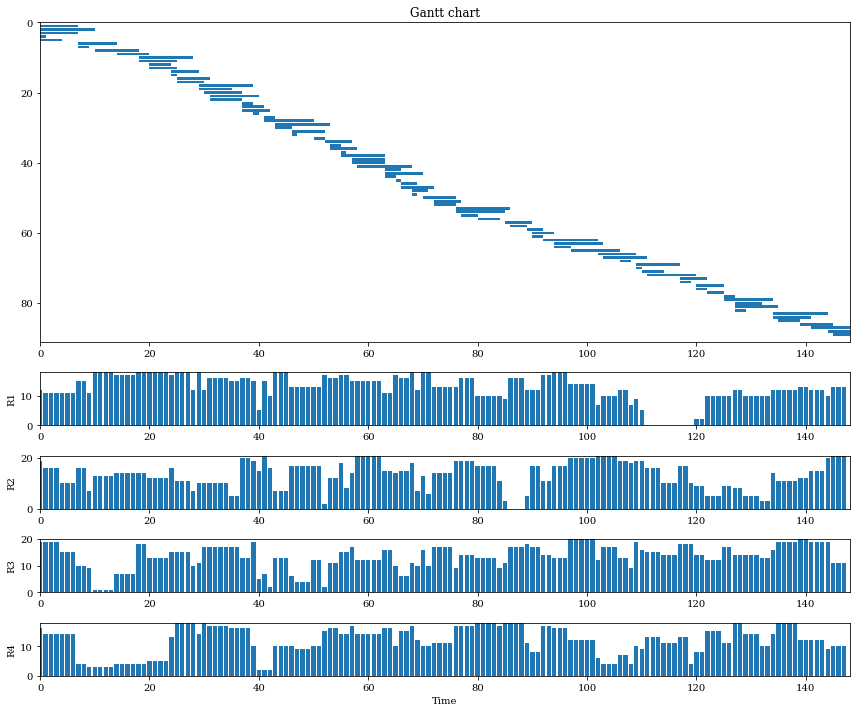

In [247]:
init_sol.plot()

## Heuristic solution

In [248]:
rnd_state = rnd.RandomState(SEED)

In [249]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(most_mobile_removal)
# alns.add_destroy_operator(non_peak_removal)
# alns.add_destroy_operator(critical_path_removal)

alns.add_repair_operator(random_insert)

In [253]:
iters = 50
crit = RecordToRecordTravel(15, 1, (15 - 1) / iters)
weights = SegmentedWeights([3, 2, 1, 0.5], 1, 1, 0.8)

res = alns.iterate(init_sol, weights, crit, iterations=iters)

sol = res.best_state
obj = sol.objective()

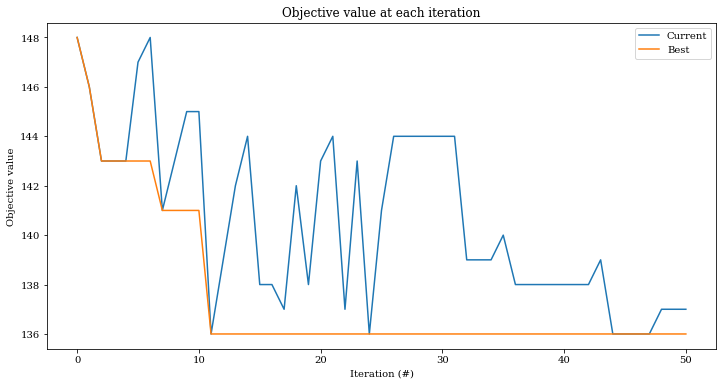

In [254]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax)

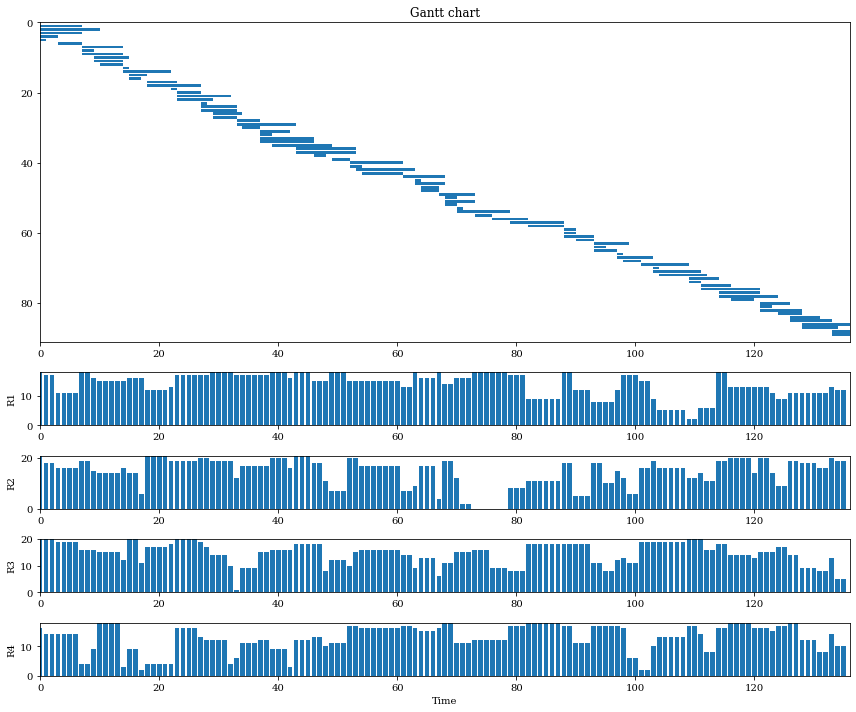

In [255]:
sol.plot()